### Выполнила: Ковалева Екатерина Сергеевна  НИЯУ МИФИ группа М24-525

## Imports

In [ ]:
!pip install missingno


In [49]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import numpy as np
import re
import seaborn as sns


# 1.Загрузите данные: ratings.csv, books.csv, tags.csv, book_tags.csv.

## Первый взгляд на данные

In [11]:
books = pd.read_csv('/home/administrator/Desktop/IDE/Recomendation/books.csv')
ratings = pd.read_csv('/home/administrator/Desktop/IDE/Recomendation/ratings.csv')
tags =  pd.read_csv('/home/administrator/Desktop/IDE/Recomendation/tags.csv')
book_tags = pd.read_csv('/home/administrator/Desktop/IDE/Recomendation/book_tags.csv')

In [6]:
books.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


In [10]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [12]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [13]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


## 1.2 EDA

In [14]:
books.shape

(10000, 23)

In [19]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

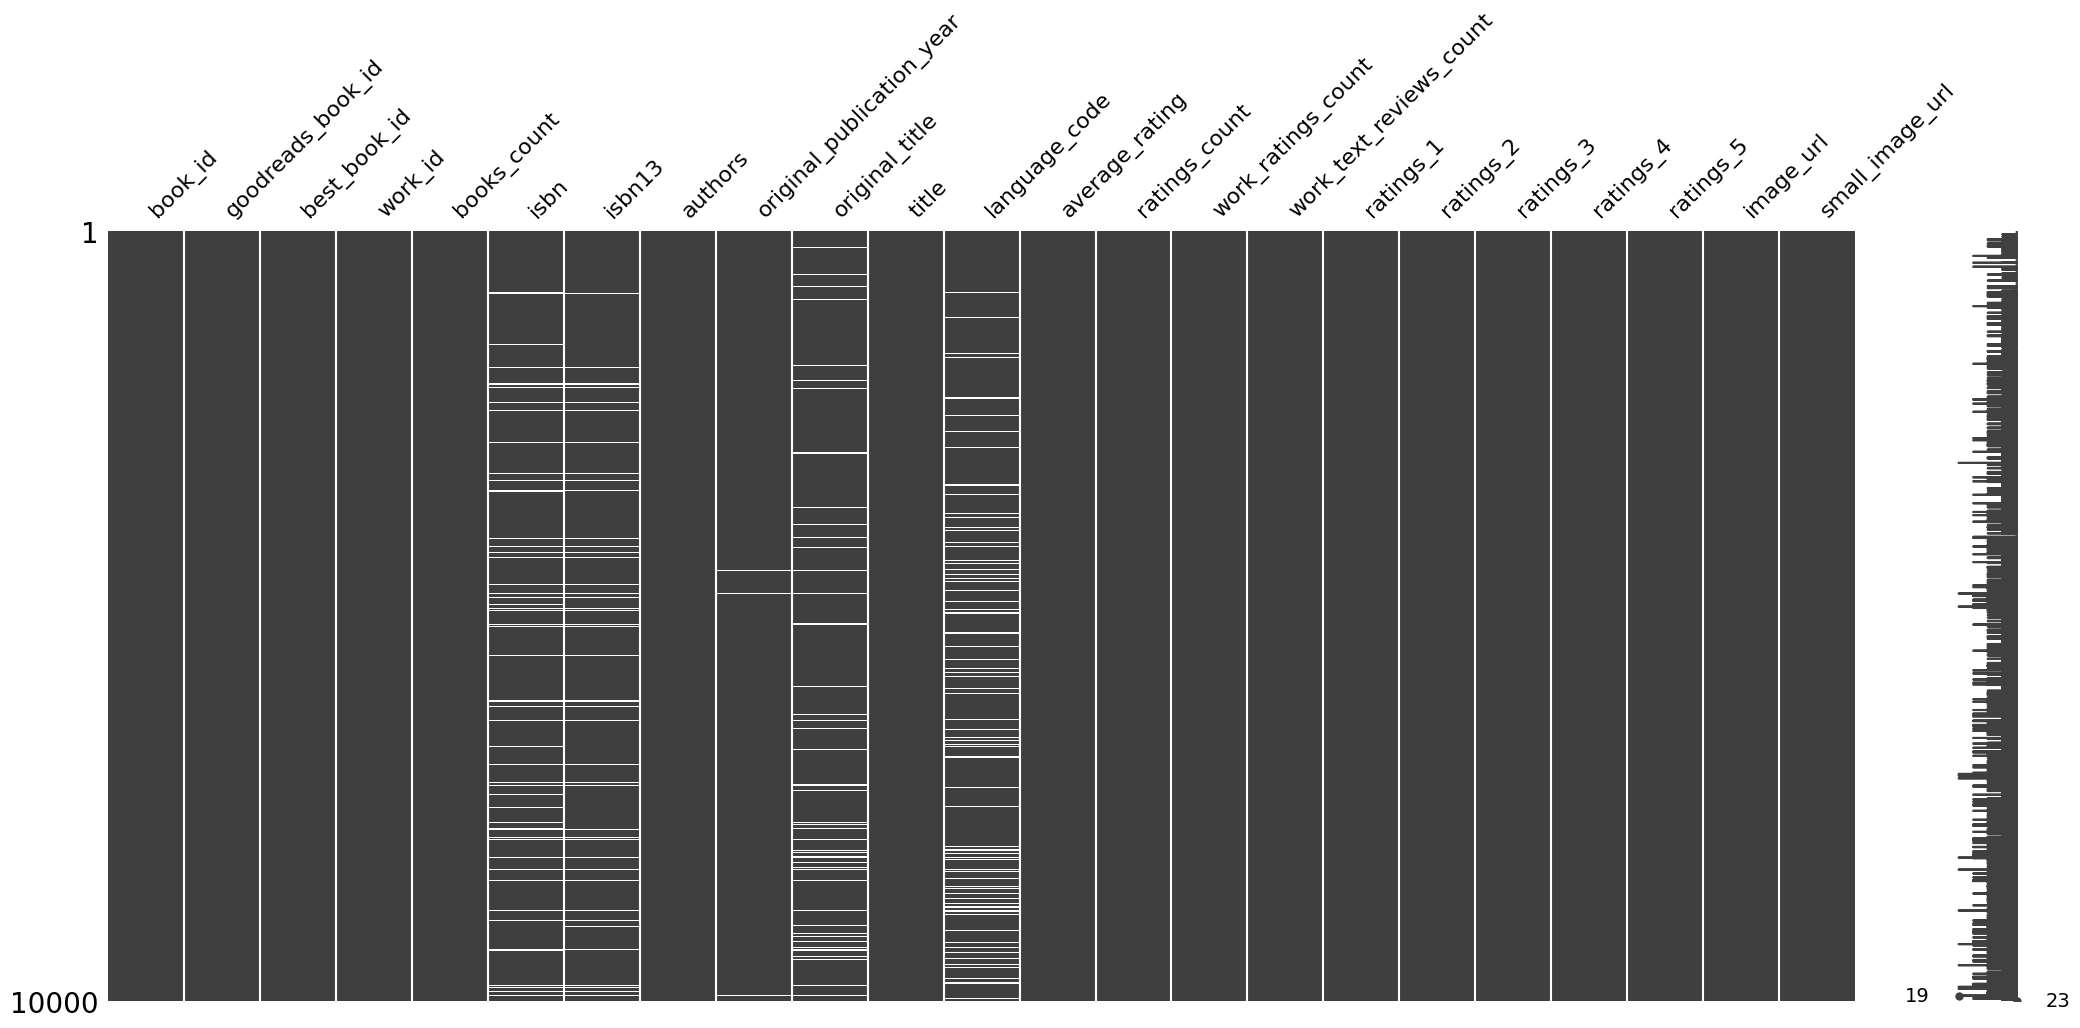

In [18]:
msno.matrix(books)
plt.show()

**Итак, нули в наличии в ряде колонок. Попробуем по возможности дозаполнить их.И мы попробуем OpenLibrary**

**Заполнение года**

In [25]:

def get_year_by_isbn(isbn):
    """
    Получает год первоначальной публикации книги по её ISBN через Open Library API.

    Функция очищает ISBN от дефисов и пробелов, проверяет длину (должна быть 10 или 13 символов),
    формирует корректный URL и делает запрос к Open Library. Если в ответе есть поле 'publish_date',
    извлекает из него год (поддерживает как целые числа, так и строки вида "1998" или "Jan 1998").

    Parameters
    ----------
    isbn : str, float, int or None
        ISBN книги. Может быть строкой с дефисами/пробелами, числом или NaN.

    Returns
    -------
    int or None
        Год публикации в виде целого числа, если успешно найден; иначе None.
    """
    if pd.isna(isbn) or not str(isbn).strip():
        return None
    isbn_clean = str(isbn).replace('-', '').replace(' ', '')
    if len(isbn_clean) not in (10, 13):
        return None
    url = f"https://openlibrary.org/isbn/{isbn_clean}.json"  
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            pub_date = data.get('publish_date')
            if pub_date:
                if isinstance(pub_date, str):
                    year_match = re.search(r'\b(1[89]\d{2}|20[012]\d)\b', pub_date)
                    if year_match:
                        return int(year_match.group(1))
                elif isinstance(pub_date, int):
                    return pub_date
    except Exception:
        pass
    return None



Найдено 21 книг с пропущенным годом. Начинаем поиск...
'Twilight: The Complete Illustrated Movie Companion' -> не найден
'Dr. Seuss's Green Eggs and Ham: For Soprano, Boy Soprano, and Orchestra' -> не найден
'Absolute Boyfriend, Vol. 1' -> 2006
'The Lord of the Rings: Weapons and Warfare' -> 2003
'Marked / Betrayed / Chosen / Untamed / Hunted (House of Night #1-5)' -> не найден
'The Lord of the Rings: The Return of the King: Visual Companion' -> не найден
'BookRags Summary:  A Storm of Swords' -> не найден
'The Doomsday Key (Sigma Force, #6)' -> 2010
'A Shade of Blood (A Shade of Vampire, #2)' -> 2013
'The 8th Habit: From Effectiveness to Greatness' -> не найден
'A Tale of Two Cities / Great Expectations' -> 2011
'Nancy Drew: #1-64' -> 1962
'Pretty Little Liars (TV Series)' -> не найден
'Dear Zoo: A Lift-the-Flap Book' -> 2007
'Giraffes Can't Dance' -> 1999
'Ralph S. Mouse by Beverly Cleary: Teacher Guide (Novel Units)' -> 1999
'The Worst Witch (Worst Witch, #1)' -> 1974
'Trouble Is My

In [ ]:
def get_year_by_title(title):
    """
    Получает год первоначальной публикации книги по её названию через Open Library Search API.

    Функция кодирует название (заменяет пробелы на '+'), отправляет запрос с limit=1
    и извлекает поле 'first_publish_year' из первого результата.

    Parameters
    ----------
    title : str or None
        Название книги. Должно быть непустой строкой.

    Returns
    -------
    int or None
        Год публикации в виде целого числа, если найден в первом результате поиска; иначе None.
    """
    if pd.isna(title) or not str(title).strip():
        return None
    title_clean = str(title).strip().replace(' ', '+')
    url = f"https://openlibrary.org/search.json?title={title_clean}&limit=1"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            if data.get('docs'):
                year = data['docs'][0].get('first_publish_year')
                if year is not None:
                    return int(year)
    except Exception:
        pass
    return None

In [ ]:
missing_mask = books['original_publication_year'].isna()
missing_books = books[missing_mask]

found_years = []
for idx, row in missing_books.iterrows():
    year = None
    if pd.notna(row['isbn']):
        year = get_year_by_isbn(row['isbn'])
    if year is None and pd.notna(row['isbn13']):
        year = get_year_by_isbn(row['isbn13'])
    if year is None:
        year = get_year_by_title(row['title'])
    
    found_years.append(float(year) if year is not None else np.nan)
    status = year if year is not None else "не найден"
    print(f"'{row['title']}' -> {status}")
    time.sleep(0.6)

books.loc[missing_mask, 'original_publication_year'] = found_years

remaining_missing = books['original_publication_year'].isna().sum()
print(f"\nГотово! Пропущенных значений осталось: {remaining_missing} из {len(missing_books)}")

result = books.loc[missing_mask, ['book_id', 'title', 'isbn', 'isbn13', 'original_publication_year']]
print("\nОбновлённые записи (первые 10):")
result.head(10)

**Заполнение языка**

In [28]:
def get_language_by_isbn(isbn):
    """
    Получает код языка книги по её ISBN через Open Library API.

    Функция очищает ISBN от дефисов и пробелов, проверяет длину (10 или 13 символов),
    отправляет запрос к Open Library и извлекает код языка из поля 'languages'.
    Формат ответа: [{'key': '/languages/eng'}] → возвращается 'eng'.

    Parameters
    ----------
    isbn : str, float, int or None
        ISBN книги. Может содержать дефисы, пробелы или быть числом.

    Returns
    -------
    str or None
        Код языка (например, 'eng', 'spa', 'fre'), если найден; иначе None.
    """
    if pd.isna(isbn) or not str(isbn).strip():
        return None
    isbn_clean = str(isbn).replace('-', '').replace(' ', '')
    if len(isbn_clean) not in (10, 13):
        return None
    url = f"https://openlibrary.org/isbn/{isbn_clean}.json"  
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            lang = data.get('languages')
            if lang and isinstance(lang, list) and len(lang) > 0:
                lang_key = lang[0].get('key', '')
                if '/languages/' in lang_key:
                    return lang_key.split('/')[-1]
    except Exception:
        pass
    return None


def get_language_by_title(title):
    """
    Получает код языка книги по её названию через Open Library Search API.

    Функция кодирует название (заменяет пробелы на '+'), отправляет запрос с limit=1
    и извлекает язык из поля 'language' первого результата (например, ['eng'] → 'eng').

    Parameters
    ----------
    title : str or None
        Название книги. Должно быть непустой строкой.

    Returns
    -------
    str or None
        Код языка (например, 'eng'), если найден в первом результате; иначе None.
    """
    if pd.isna(title) or not str(title).strip():
        return None
    title_clean = str(title).strip().replace(' ', '+')
    url = f"https://openlibrary.org/search.json?title={title_clean}&limit=1"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            if data.get('docs'):
                lang_list = data['docs'][0].get('language')
                if lang_list and isinstance(lang_list, list) and len(lang_list) > 0:
                    return lang_list[0]
    except Exception:
        pass
    return None

In [27]:
missing_lang = books['language_code'].isna()
for idx in books[missing_lang].index:
    lang = None
    if pd.notna(books.at[idx, 'isbn']):
        lang = get_language_by_isbn(books.at[idx, 'isbn'])
    if lang is None and pd.notna(books.at[idx, 'isbn13']):
        lang = get_language_by_isbn(books.at[idx, 'isbn13'])
    if lang is None:
        lang = get_language_by_title(books.at[idx, 'title'])
    
    if lang:
        books.at[idx, 'language_code'] = lang
    time.sleep(0.5)

In [32]:
books['language_code'].isna().sum()

284

In [ ]:
books['language_code'].fillna(books['language_code'].mode()[0], inplace=True) #оставшиеся заполнила модой

In [ ]:
books['original_title'] = books['original_title'].fillna(books['title']) ### где не хватало оригинального названия заполнила по названию

**что осталось по нулям?**

In [34]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9993 non-null   float64
 9   original_title             10000 non-null  object 
 10  title                      10000 non-null  object 
 11  language_code              10000 non-null  object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

**Что по дубликатам?**

In [36]:
books[books.title.duplicated(keep=False)==True].sort_values('title')

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1291,1292,5413,5413,40802405,22,385516487,9.780386e+12,"Stephen King, Jerry N. Uelsmann",2005.0,'Salem's Lot The Illustrated Edition,'Salem's Lot,eng,4.25,72797,74725,482,460,1854,12040,24920,35451,https://images.gr-assets.com/books/1320478491m...,https://images.gr-assets.com/books/1320478491s...
348,349,11590,11590,3048937,211,450031063,9.780450e+12,Stephen King,1975.0,Salem's Lot,'Salem's Lot,en-GB,3.99,228680,246360,6167,2713,11724,57171,89196,85556,https://images.gr-assets.com/books/1327891565m...,https://images.gr-assets.com/books/1327891565s...
5267,5268,327242,327242,317880,5,078948045X,6.355171e+11,Sarah Simblet,2001.0,Anatomy for the Artist,Anatomy for the Artist,en-US,3.97,17000,17050,49,767,1255,3413,3978,7637,https://images.gr-assets.com/books/1309295064m...,https://images.gr-assets.com/books/1309295064s...
4185,4186,327246,327246,317884,14,1402735421,9.781403e+12,Jenő Barcsay,1953.0,Művészeti Anatómia,Anatomy for the Artist,eng,3.97,21640,21688,24,893,1421,4389,5692,9293,https://images.gr-assets.com/books/1328858785m...,https://images.gr-assets.com/books/1328858785s...
6480,6481,384597,384597,1303332,24,571169341,9.780571e+12,Tom Stoppard,1993.0,Arcadia,Arcadia,en-US,4.19,15362,16149,749,291,713,2408,4948,7789,https://images.gr-assets.com/books/1463617930m...,https://images.gr-assets.com/books/1463617930s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,162,49552,49552,3324344,675,NaN,NaN,"Albert Camus, Matthew Ward",1942.0,L’Étranger,The Stranger,eng,3.96,420600,483623,14836,10563,28920,100140,174957,169043,https://images.gr-assets.com/books/1349927872m...,https://images.gr-assets.com/books/1349927872s...
7760,7761,323289,323289,30783,64,044619154X,9.780446e+12,Sandra Brown,1995.0,Witness,The Witness,eng,3.98,10558,14481,751,144,579,3200,6017,4541,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
2371,2372,12716613,12716613,17851429,75,399159371,9.780399e+12,Nora Roberts,2012.0,The Witness,The Witness,fre,4.19,40943,49415,4008,448,1380,7822,18688,21077,https://images.gr-assets.com/books/1329921937m...,https://images.gr-assets.com/books/1329921937s...
7002,7003,825,825,934262,30,553573861,9.780554e+12,Neal Stephenson,1988.0,Zodiac,Zodiac,eng,3.70,13353,14803,569,118,920,4989,6026,2750,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


**У нас в наличии 69 дублированных книг (включая оригиналы). Они могут отличаться от оригиналов некоторыми функциями, такими как (original_publication_year, language_code). Так что мы их сохраним.**


In [37]:
books.to_csv('books_new.csv', index=False)

## EDA

In [44]:
def plot_books_by(df, col, n_rows=10):
    df_top = df.head(n_rows)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=col, y='title', data=df_top, palette='viridis')
    plt.title(f'Best {n_rows} books by {col.replace("_", " ").capitalize()}', weight='bold')
    plt.xlabel(f'Score of {col}')
    plt.ylabel('Book Title')
    plt.tight_layout()
    plt.show()

In [39]:
important_columns = ['title','authors','average_rating','ratings_count','work_text_reviews_count']

## Top Rated Books

In [40]:
book_sorted_ratings = books[books['ratings_count']>=1000].sort_values('average_rating', ascending=False)
book_sorted_ratings[important_columns].head(15)

,title,authors,average_rating,ratings_count,work_text_reviews_count
3627,The Complete Calvin and Hobbes,Bill Watterson,4.82,28900,861
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",4.77,33220,156
861,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77,73572,7261
8853,Mark of the Lion Trilogy,Francine Rivers,4.76,9081,731
7946,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76,8953,262
4482,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,4.75,22351,264
6360,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,4.74,16766,149
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74,190050,6508
3752,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73,24618,882
6919,The Indispensable Calvin and Hobbes,Bill Watterson,4.73,14597,325


**книги с не менее чем 1000 оценок топ**

/tmp/ipykernel_696610/1586049375.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='title', data=df_top, palette='viridis')


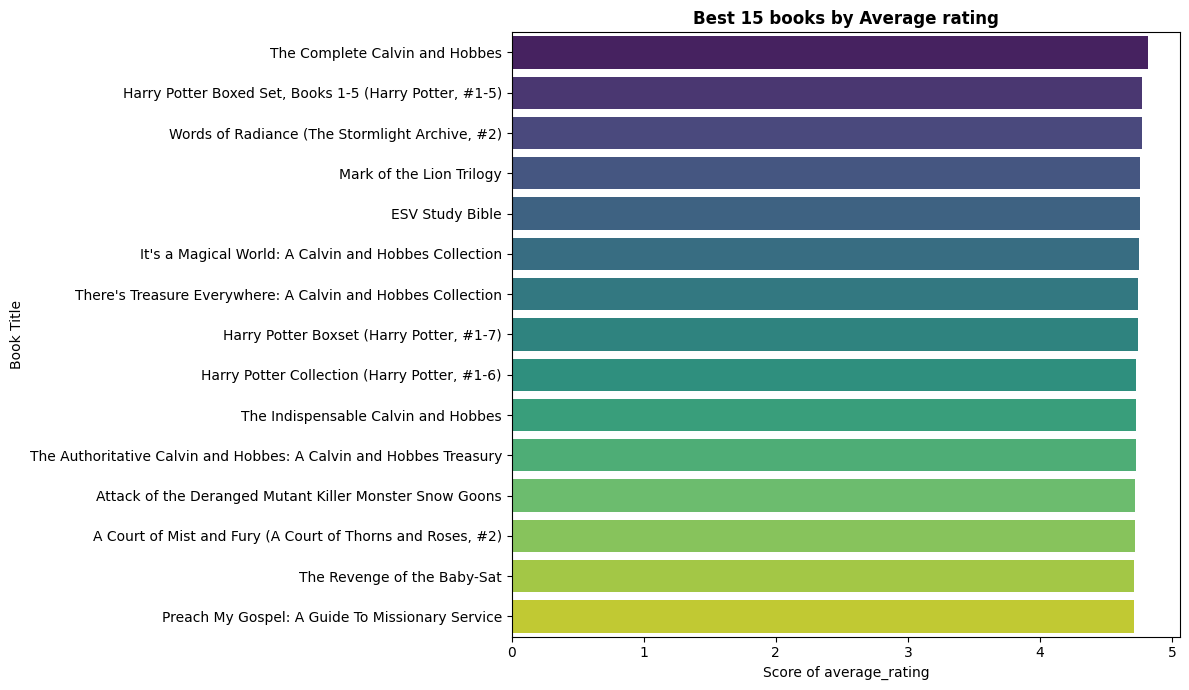

In [45]:
plot_books_by(book_sorted_ratings, 'average_rating', 15)

/tmp/ipykernel_696610/1586049375.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='title', data=df_top, palette='viridis')


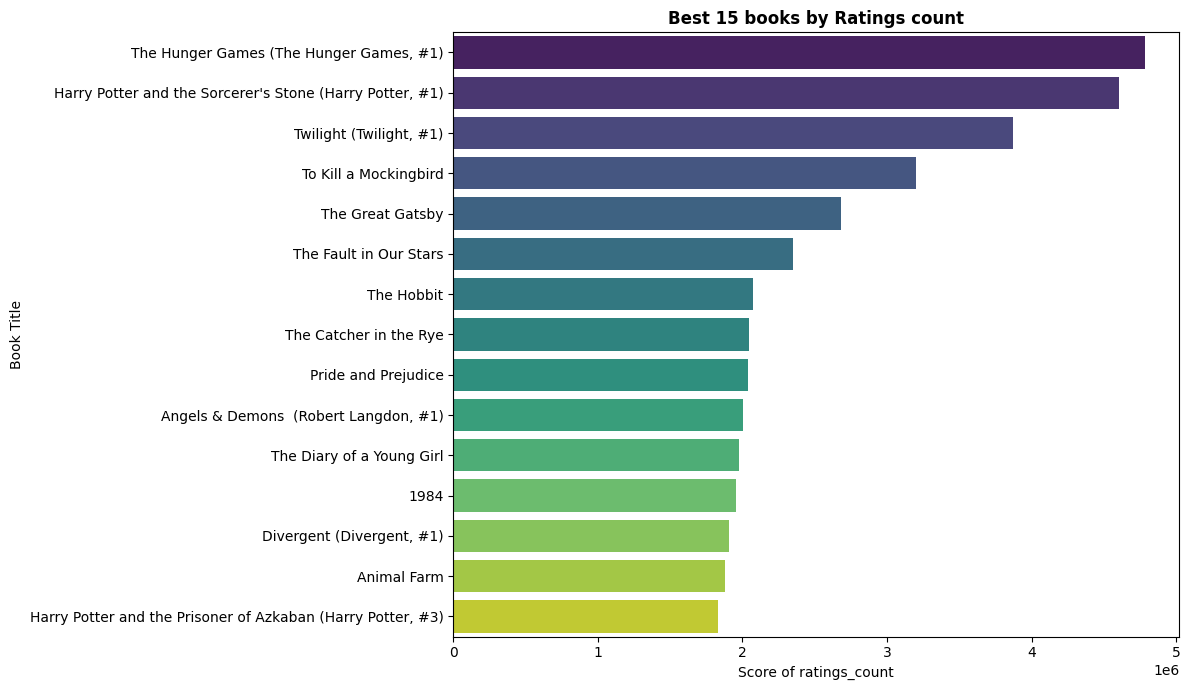

In [46]:
book_sorted_ratings_count = books.sort_values('ratings_count', ascending=False)
plot_books_by(book_sorted_ratings_count, 'ratings_count', 15)

**Top Text-Reviewed Books**

/tmp/ipykernel_696610/1586049375.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='title', data=df_top, palette='viridis')


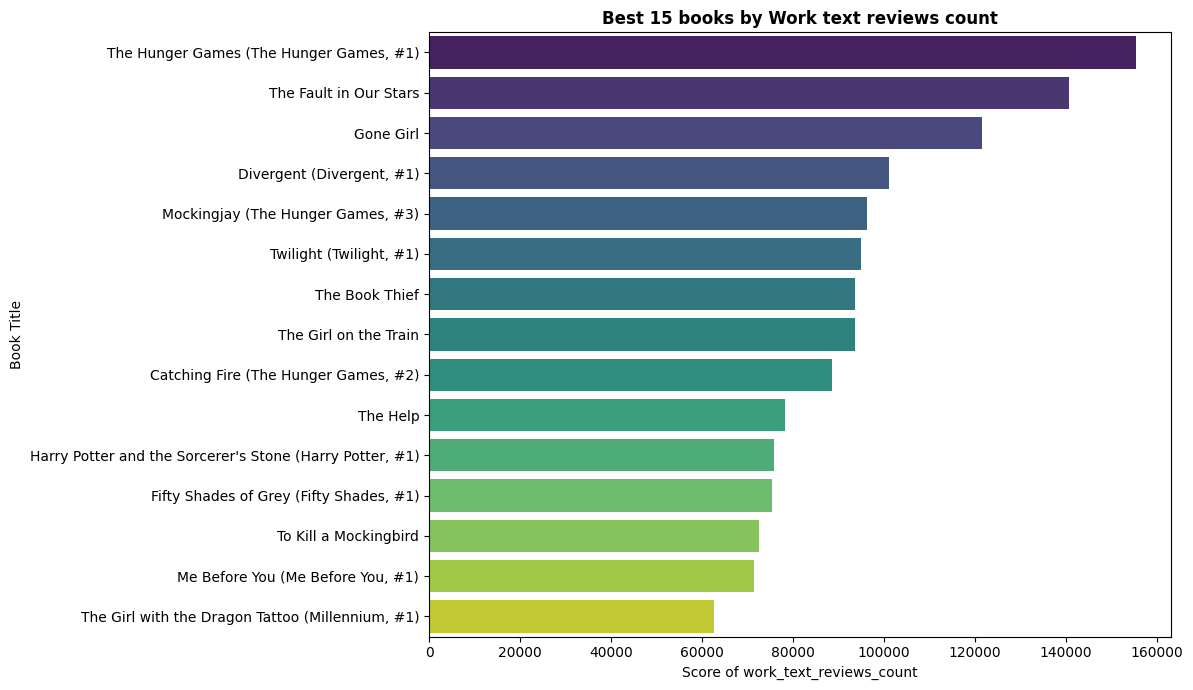

In [48]:
book_sorted_reviews_count = books[books['ratings_count']>=1000].sort_values('work_text_reviews_count', ascending=False)
plot_books_by(book_sorted_reviews_count, 'work_text_reviews_count', 15)


## Ratings

## Распределение оценок. Есть ли смещение в сторону высоких оценок?

/tmp/ipykernel_696610/3586149739.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


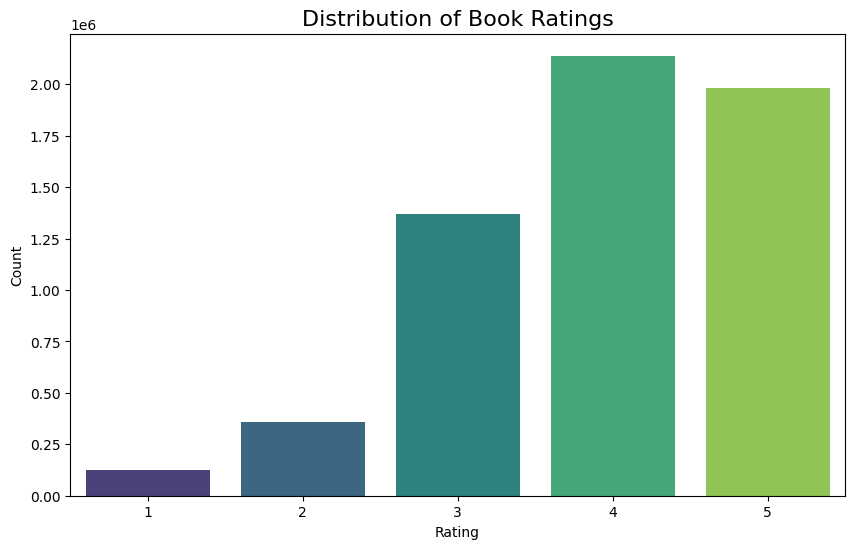

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Book Ratings', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Да, существует явный перекос в сторону высоких оценок. Пользователи гораздо чаще ставят оценку 4 или 5, чем 1 или 2. Это обычное явление в рейтинговых системах.**

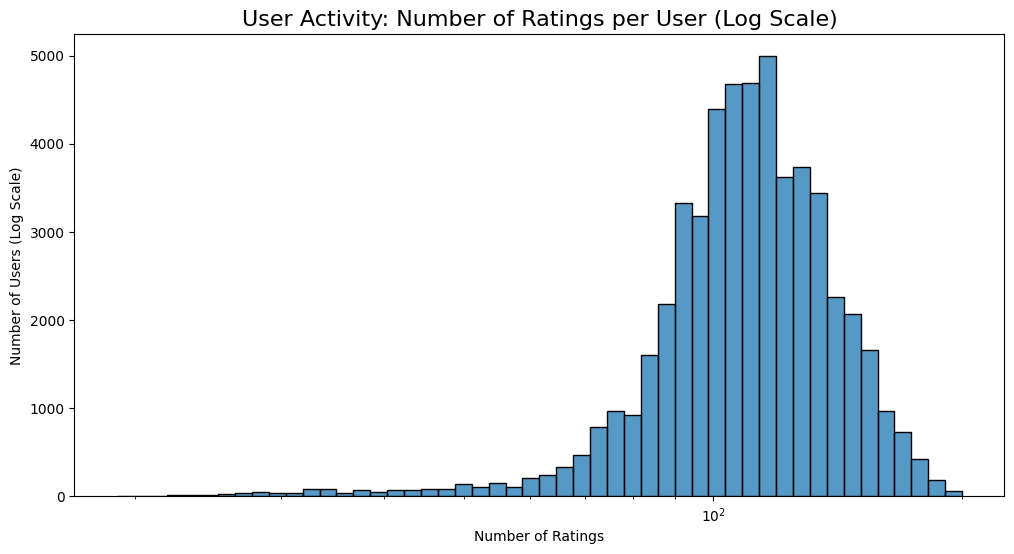

Total users: 53424
Users with fewer than 5 ratings: 0


In [51]:
user_rating_counts = ratings.groupby('user_id')['rating'].count()

plt.figure(figsize=(12, 6))
sns.histplot(user_rating_counts, bins=50, kde=False, log_scale=True)
plt.title('User Activity: Number of Ratings per User (Log Scale)', fontsize=16)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (Log Scale)')
plt.show()

print(f"Total users: {ratings['user_id'].nunique()}")
print(f"Users with fewer than 5 ratings: {sum(user_rating_counts < 5)}")

**Это классическое распределение по принципу "длинного хвоста". Подавляющее большинство пользователей оценили лишь небольшое количество книг, в то время как несколько "опытных пользователей" оценили многие из них. Это подчеркивает проблему "холодного запуска" и нехватку данных.**

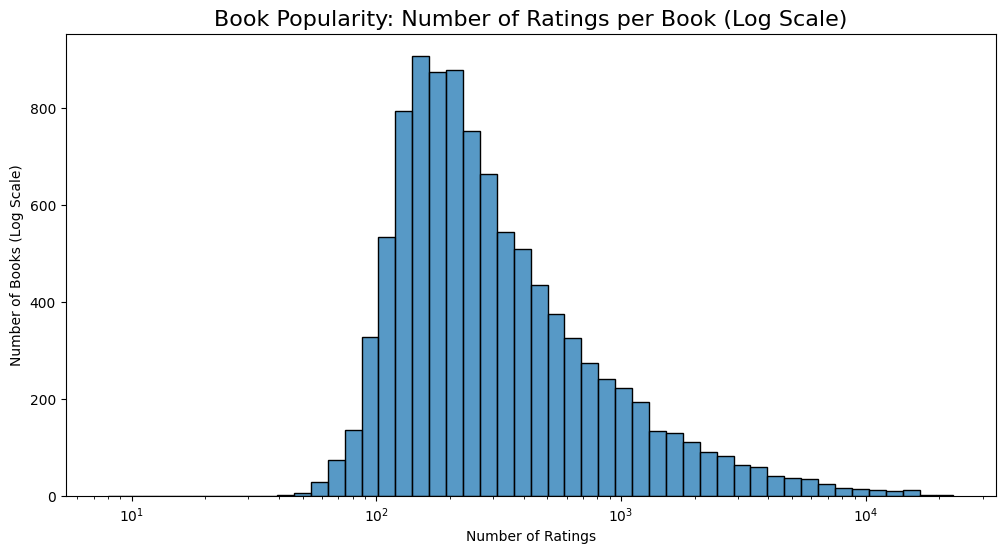

Total books rated: 10000
Books with fewer than 5 ratings: 0


In [52]:
book_rating_counts = ratings.groupby('book_id')['rating'].count()

plt.figure(figsize=(12, 6))
sns.histplot(book_rating_counts, bins=50, kde=False, log_scale=True)
plt.title('Book Popularity: Number of Ratings per Book (Log Scale)', fontsize=16)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books (Log Scale)')
plt.show()

print(f"Total books rated: {ratings['book_id'].nunique()}")
print(f"Books with fewer than 5 ratings: {sum(book_rating_counts < 5)}")

**Как и активность пользователей, популярность книг также имеет длинную цепочку распределения. Многие книги имеют очень низкий рейтинг, в то время как небольшое количество книг пользуются огромной популярностью. Это называется смещением популярности. Наша система рекомендаций должна предлагать не только популярные книги.**

## Tags

### Какие жанры или темы наиболее распространены?

/tmp/ipykernel_696610/2202969716.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tag_counts.index, x=tag_counts.values, palette='mako')


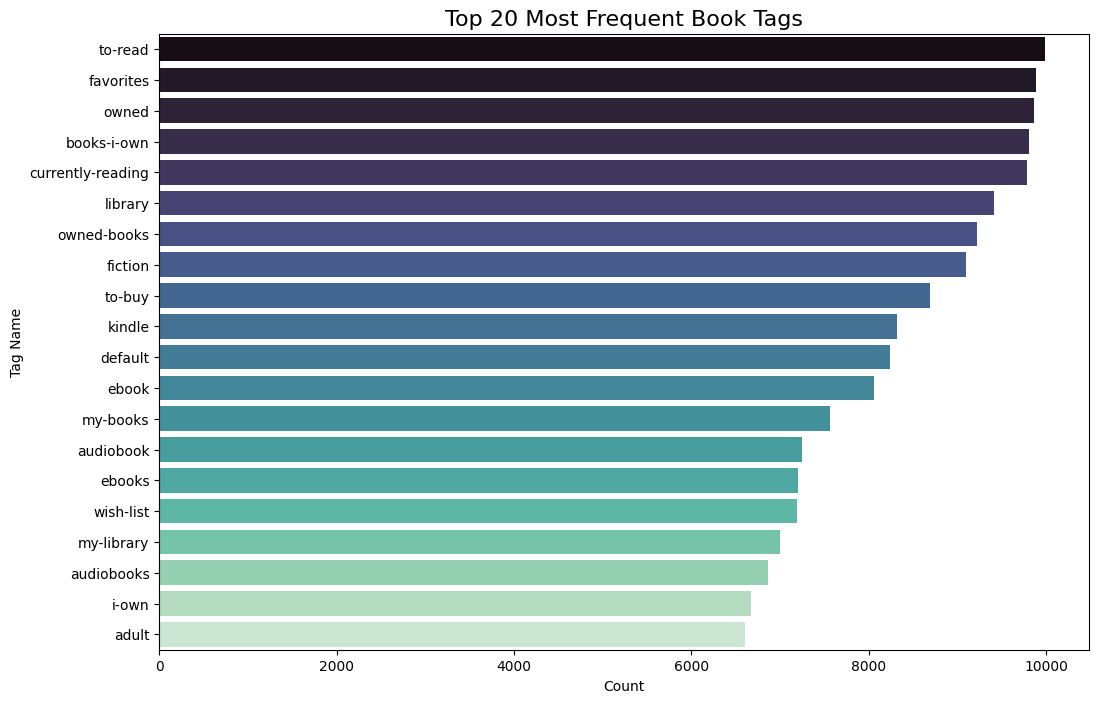

In [53]:
merged_tags = pd.merge(book_tags, tags, on='tag_id')

tag_counts = merged_tags['tag_name'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=tag_counts.index, x=tag_counts.values, palette='mako')
plt.title('Top 20 Most Frequent Book Tags', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Tag Name')
plt.show()

**такие теги, как "для чтения", "избранное" и "читается в данный момент", являются пользовательскими названиями полок и не описывают содержимое. Для модели, основанной на контенте, мы должны сосредоточиться на жанровых тегах, таких как "фэнтези", "для молодежи", "художественная литература" и т.д.**

## Сводка и выводы по результатам EDA

**1. Качество данных и предварительная обработка**

Исходный датасет содержал пропущенные значения в нескольких важных столбцах, включая isbn, original_publication_year и language_code. Был выполнен значительный этап обогащения данных: с помощью API OpenLibrary недостающие годы публикации и языковые коды были заполнены на основе ISBN и названий книг. Такой подход позволил существенно сократить количество пропусков, сделав датасет более надёжным для анализа. Оставшиеся пропущенные значения были обработаны с использованием адекватных стратегий: например, недостающие значения original_title заменялись основным названием книги, а оставшиеся пропуски в language_code — модой (наиболее частым значением).

**2.Распределение рейтингов: смещение в сторону позитивных оценок**

Распределение пользовательских рейтингов сильно смещено в сторону высоких оценок: рейтинги 4 и 5 встречаются значительно чаще, чем 1 или 2. Это указывает на позитивное смещение — типичную особенность систем рейтинга, где пользователи чаще оценивают те книги, которые им понравились. Это смещение важно учитывать, поскольку оно может повлиять на способность модели корректно обрабатывать негативные предпочтения.

**3.Активность пользователей и популярность книг: «длинный хвост»**

Как поведение пользователей при выставлении рейтингов, так и популярность книг демонстрируют классическое распределение «длинного хвоста», что выявляет две критические проблемы для рекомендательных систем:

Разреженность и проблема «холодного старта» для пользователей: подавляющее большинство пользователей поставили всего несколько оценок, в то время как небольшая группа «суперпользователей» проявляет высокую активность. Эта разреженность означает, что для большинства пользователей имеется крайне мало данных, что затрудняет персонализированные рекомендации, особенно для новых пользователей (проблема «холодного старта»).
Смещение популярности: небольшое число книг чрезвычайно популярно и получает непропорционально большое количество рейтингов. В то же время большинство книг относится к «длинному хвосту» и имеет очень мало оценок. Это смещение популярности может привести к тому, что простые модели будут постоянно рекомендовать одни и те же популярные книги, снижая разнообразие рекомендаций и уменьшая шансы пользователей открыть для себя нишевые издания.

**4.Анализ тегов: содержание против поведения пользователя**

Анализ самых частых тегов показал, что многие из них не описывают содержание книги, а представляют собой пользовательские метки для личной организации, такие как «to-read» («прочитать»), «favorites» («избранное») и «currently-reading» («читаю сейчас»). Хотя такие теги дают представление о поведении пользователей, они мало полезны для контентной рекомендательной модели. Для этой цели гораздо ценнее жанровые и тематические теги, такие как «fantasy» («фэнтези»), «young-adult» («подростковая литература») и «fiction» («художественная литература»), которым следует отдавать приоритет при создании признаков.
